In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt 

In [14]:
tf.random.set_seed(42)
np.random.seed(42)

In [15]:
data = pd.read_csv('../data/energy_data_cleaned.csv')

In [16]:
building_ids = data['building_id']

X = data.drop(['target', 'site_id', 'building_id'], axis=1)
y = data['target']


In [17]:
data['timestamp'] = pd.to_datetime({'year': 2016, 'month': data['month'], 'day': data['day'], 'hour': data['hour']})
data = data.sort_values(['building_id', 'timestamp'])
sequence_length = 24 

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Criar sequências
X_seq, y_seq = [], []
for b_id in np.unique(building_ids):
    bld_mask = building_ids == b_id
    feats_bld = X_scaled[bld_mask]
    target_bld = y_scaled[bld_mask]
    
    for i in range(len(feats_bld) - sequence_length):
        X_seq.append(feats_bld[i:i+sequence_length])
        y_seq.append(target_bld[i+sequence_length])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Divisão entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


In [18]:
def r2_metric(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())


In [19]:
def build_rnn_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(64, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse', r2_metric])
    return model

rnn_model = build_rnn_model(X_train.shape[1:])  # (timesteps, features)
rnn_model.summary()

/opt/anaconda3/envs/meu_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,105 (27.75 KB)

 Trainable params: 7,105 (27.75 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    verbose=1
)

Epoch 1/50
24398/24398 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - loss: 0.1668 - mae: 0.2730 - mse: 0.1668 - r2_metric: 0.8290 - val_loss: 0.0891 - val_mae: 0.1904 - val_mse: 0.0891 - val_r2_metric: 0.9083
Epoch 2/50
24398/24398 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 0.1020 - mae: 0.1959 - mse: 0.1020 - r2_metric: 0.8957 - val_loss: 0.0828 - val_mae: 0.1803 - val_mse: 0.0828 - val_r2_metric: 0.9150
Epoch 3/50
24398/24398 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.0888 - mae: 0.1798 - mse: 0.0888 - r2_metric: 0.9090 - val_loss: 0.0724 - val_mae: 0.1595 - val_mse: 0.0724 - val_r2_metric: 0.9257
Epoch 4/50
24398/24398 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.0824 - mae: 0.1705 - mse: 0.0824 - r2_metric: 0.9155 - val_loss: 0.0709 - val_mae: 0.1578 - val_mse: 0.0709 - val_r2_metric: 0.9274
Epoch 5/50
24398/24398 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 0.0803 - mae: 0.1679 - mse: 0.0803 - r2_metric: 0.9177 - val_loss: 0.0766 - val_mae: 0.1635 - val_mse: 0.0766 - val_r2_metric: 0.9215
Epoch

In [21]:
predictions_scaled = rnn_model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions_scaled)
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_orig, predictions)
mse = mean_squared_error(y_test_orig, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orig, predictions)

print("Test metrics:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")


12199/12199 ━━━━━━━━━━━━━━━━━━━━ 6s 455us/step
Test metrics:
MAE: 0.4535, MSE: 0.4388, RMSE: 0.6624, R2: 0.8749


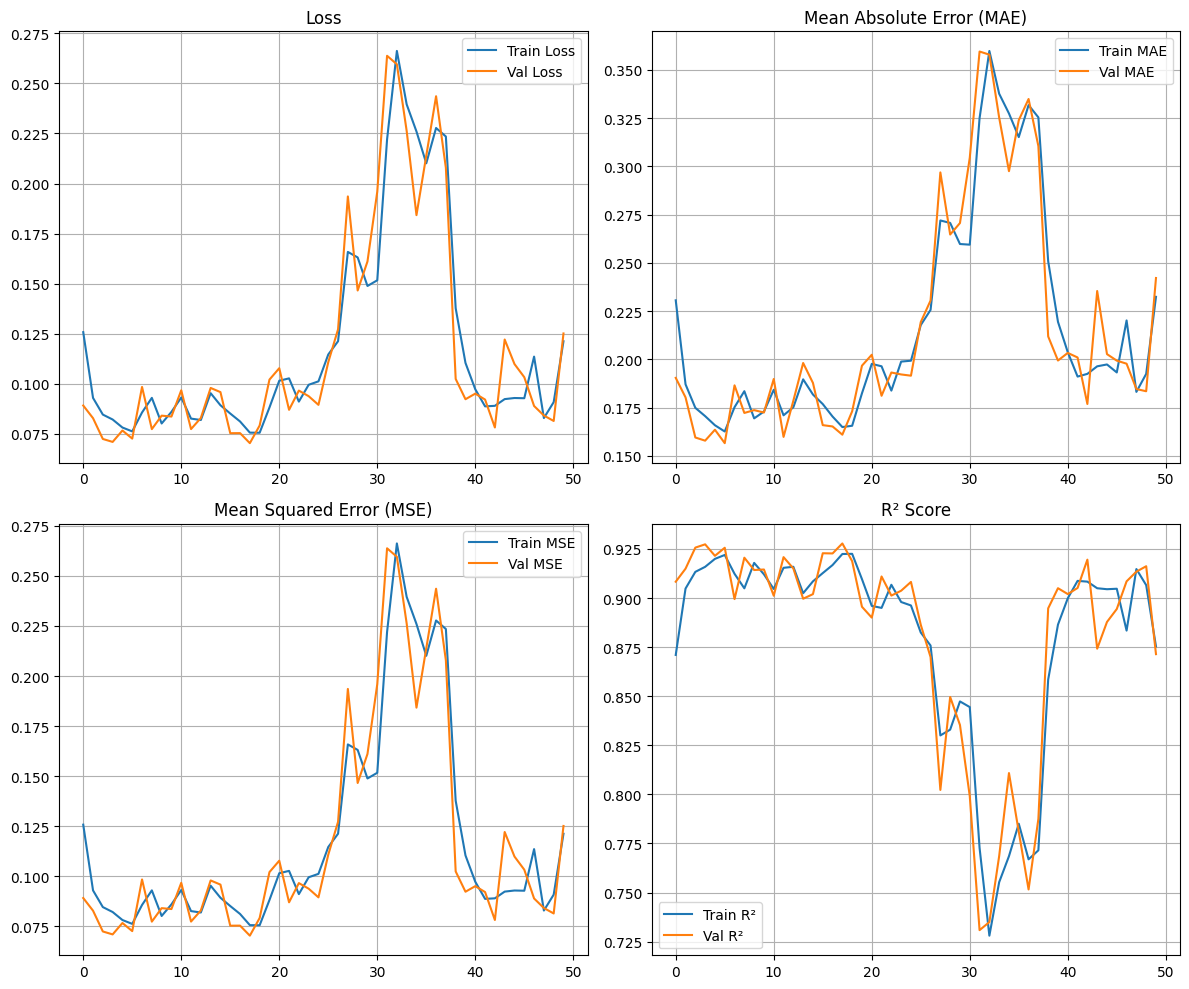

In [22]:
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.grid(True)

# Plot MAE
plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.grid(True)

# Plot MSE
plt.subplot(2, 2, 3)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.legend()
plt.title('Mean Squared Error (MSE)')
plt.grid(True)

# Plot R²
plt.subplot(2, 2, 4)
plt.plot(history.history['r2_metric'], label='Train R²')
plt.plot(history.history['val_r2_metric'], label='Val R²')
plt.legend()
plt.title('R² Score')
plt.grid(True)

plt.tight_layout()
plt.show()

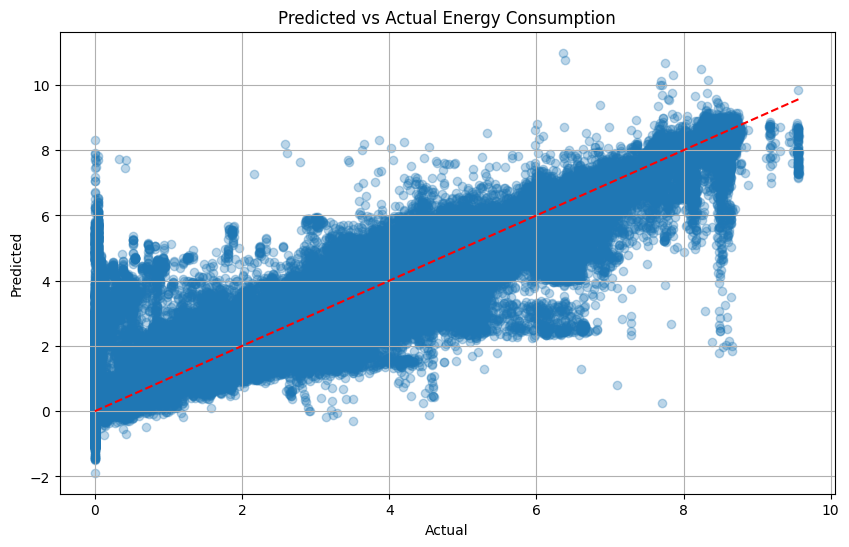

In [24]:


results_df = pd.DataFrame({
    'building_id': building_ids.iloc[X_test[:, 0, 0].astype(int)],
    'actual': y_test_orig.flatten(),
    'predicted': predictions.flatten(),
    
})


plt.figure(figsize=(10, 6))
plt.scatter(results_df['actual'], results_df['predicted'], alpha=0.3)
plt.plot([results_df['actual'].min(), results_df['actual'].max()],
         [results_df['actual'].min(), results_df['actual'].max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Energy Consumption')
plt.grid(True)
plt.show()

/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_25391/4284003574.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results_df['timestamp'] = np.tile(timestamps, len(random_building_ids))


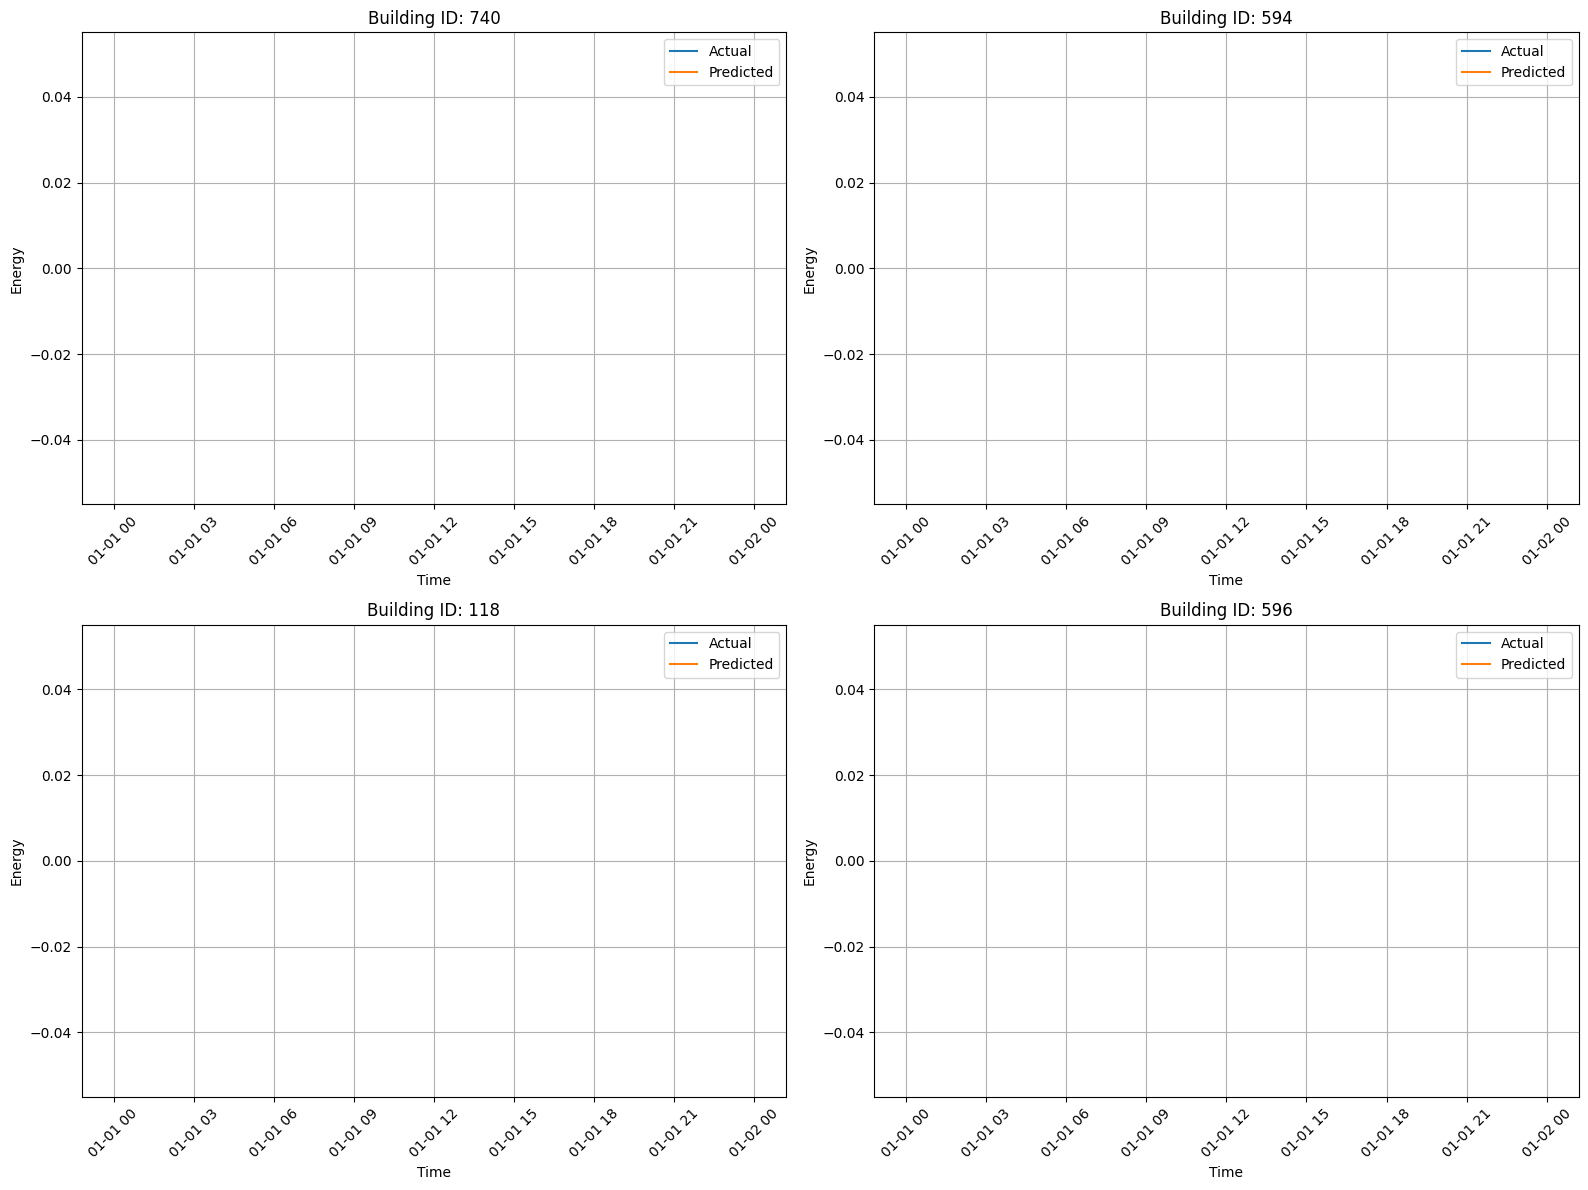

In [28]:
timestamps = []

for b_id in np.unique(building_ids):
    bld_mask = building_ids == b_id
    bld_timestamps = data['timestamp'][bld_mask].values
    timestamps.extend(bld_timestamps)

timestamps = np.array(timestamps)
# Randomly select 4 buildings for the plots
random_building_ids = np.random.choice(np.unique(building_ids), size=4, replace=False)

# Filter the results to show the last two months of predictions
filtered_results_df = results_df[results_df['building_id'].isin(random_building_ids)]
filtered_results_df['timestamp'] = np.tile(timestamps, len(random_building_ids))
filtered_results_df = filtered_results_df[filtered_results_df['timestamp'] >= '2016-10-01']
filtered_results_df = filtered_results_df.sort_values(by=['building_id', 'timestamp'])
# Convert timestamp to datetime
filtered_results_df['timestamp'] = pd.to_datetime(filtered_results_df['timestamp'])

# Plot the actual vs predicted for the selected buildings
plt.figure(figsize=(16, 12))
for i, bid in enumerate(random_building_ids):
    subset = filtered_results_df[filtered_results_df['building_id'] == bid].sort_values(by='timestamp')
    
    plt.subplot(2, 2, i + 1)
    plt.plot(subset['timestamp'], subset['actual'], label='Actual')
    plt.plot(subset['timestamp'], subset['predicted'], label='Predicted')
    plt.title(f"Building ID: {bid}")
    plt.xlabel('Time')
    plt.ylabel('Energy')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()